# Kr NEW Compare KrMap - ICAROS Map

J. A Hernando, C. Herves

May 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana
import nana.kr.icaros   as icaros

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu May 12 15:29:52 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [6]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEXT100/Kr/'

In [7]:
from os import listdir

run = 'MC00'
filenames = listdir(path+str(run))
filenames.sort()
print(len(filenames), filenames[0], filenames[-1])
filenames = [path + str(run) + '/' + ifile for ifile in filenames]

10000 dorothea_10000_kr83m.h5 dorothea_9_kr83m.h5


In [9]:
mapfilename = path + 'maps/map_NEXT100_' + str(run) + '.h5'

In [11]:
icaromap = icaros.get_map(mapfilename)

In [14]:
krmap  = krana.krmap_read('krmap' , 'krmap_NEXT100_'+str(run)+'.h5', 'KrMap')
xyprof = krana.krmap_read('xyprof', 'krmap_NEXT100_'+str(run)+'.h5', 'Profile')

In [12]:
kdst = load_dsts(filenames, "DST", "Events")

In [15]:
kdst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [16]:
names = ['event', 'time', 'S2e', 'X', 'Y', 'Z', 'DT']
sel   = (kdst.nS1 == 1) & (kdst.nS2 == 1)
mkdst = kdst[sel][names]
mkdst['R'] = np.sqrt(mkdst.X**2 + mkdst.Y**2)
mkdst.replace(np.nan, 0.)
mkdst = mkdst.rename(columns = {'S2e' : 'energy', 'X' : 'x', 'Y' : 'y', 'Z' : 'z', 'DT' : 'dtime', 'R' : 'r'})

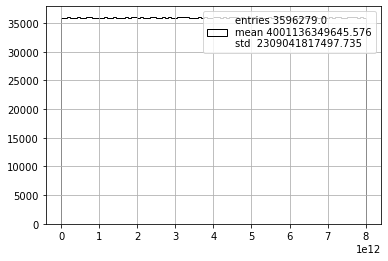

In [17]:
pltext.hist(mkdst.time, 100);

In [18]:
sels = {}
sels['r']        = ut.in_range(mkdst.r  , (0., 450))
sels['dtime']    = ut.in_range(mkdst.dtime , (0., 1450.))
sels['energy']   = ut.in_range(mkdst.energy, (10e3, 20e4))
sels['fidutial'] = (sels['r']) & (sels['dtime']) & (sels['energy'])

In [19]:
mkdst.columns

Index(['event', 'time', 'energy', 'x', 'y', 'z', 'dtime', 'r'], dtype='object')

In [ ]:
sel = sels['fidutial']
krana.plot_data(mkdst[sel], 60)

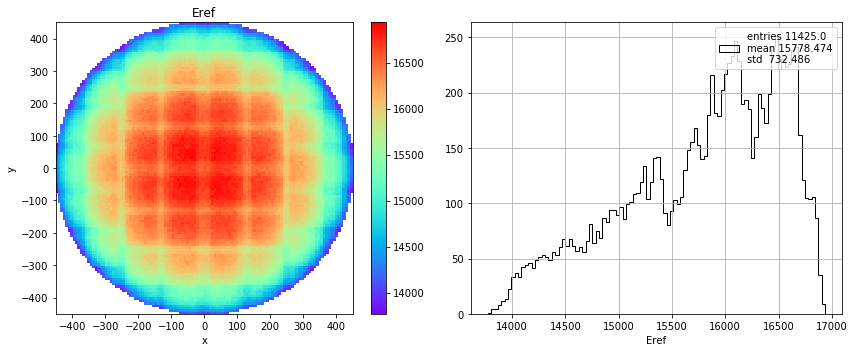

In [24]:
krana.plot_xyvar(krmap.eref, bins = krmap.bin_edges, title = 'Eref', mask = krmap.success, nbins = 100)

In [99]:
sel = sels['fidutial']
x   = mkdst[sel].x
y   = mkdst[sel].y
z   = mkdst[sel].z
dt  = mkdst[sel].dtime
ts  = mkdst[sel].time
ene = mkdst[sel].energy

coors = (x, y)
enec, _  = krana.krmap_scale(coors, dt, ene, krmap, 41.5)

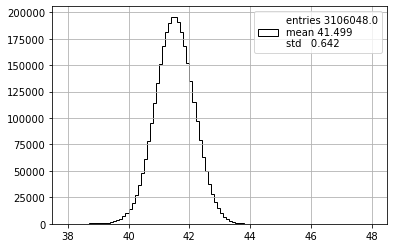

In [103]:
pltext.hist(enec, 100, (38, 48));

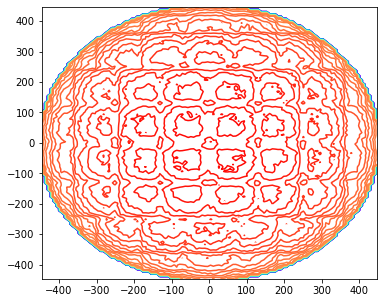

In [108]:
xymesh = np.meshgrid(*krmap.bin_centers)
pltext.canvas(1, 1)
plt.contour(*xymesh, krmap.eref, 100);

## Icaro

In [109]:
icaro_correction = icaros.get_correction(icaromap)

In [115]:
sel = sels['fidutial']
x   = mkdst[sel].x
y   = mkdst[sel].y
z   = mkdst[sel].z
dt  = mkdst[sel].dtime
ts  = mkdst[sel].time
ene = mkdst[sel].energy

ficaro = 1e3 * icaro_correction(x, y, z, ts)
eicaro = ficaro * ene

## Kr resolution

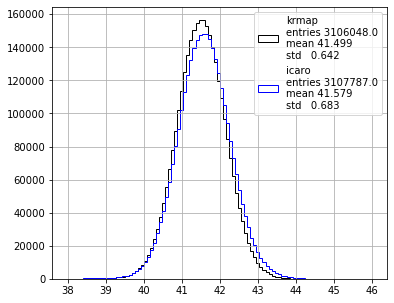

In [116]:
nbins, erange = 100, (38, 46)
pltext.canvas(1, 1)
pltext.hist(enec  , nbins, erange, label = 'krmap');
pltext.hist(eicaro, nbins, erange, label = 'icaro');

In [139]:
nsize   = len(xymesh[0].ravel())
icnorma = 1e-3/icaro_correction(xymesh[0].ravel(), xymesh[1].ravel(), np.zeros(nsize), ts[:nsize])

## Correction factor

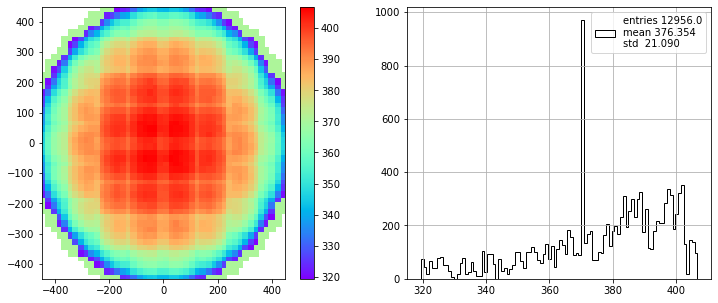

In [141]:
canvas = pltext.canvas(2, 2);
canvas(1)
plt.hist2d(xymesh[0].ravel(), xymesh[1].ravel(), weights = icnorma, bins = krmap.bin_edges);
plt.colorbar();
canvas(2)
pltext.hist(icnorma[icnorma > 0.], 100);

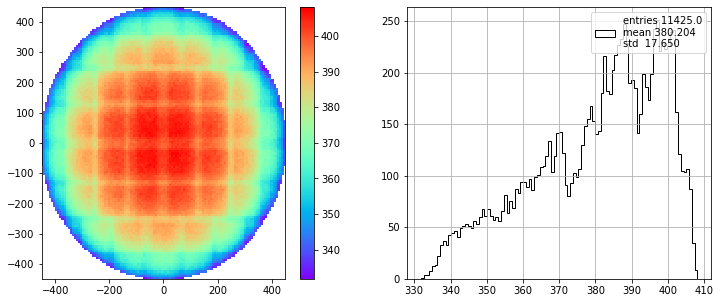

In [163]:
knorma = krmap.eref.ravel()/41.5
xsel = (~np.isnan(knorma)) & (knorma > 0.)
knorma[~xsel] = np.nan
canvas = pltext.canvas(2, 2);
canvas(1)
plt.hist2d(xymesh[0].ravel(), xymesh[1].ravel(), weights = knorma, bins = krmap.bin_edges);
plt.colorbar();
canvas(2)
pltext.hist(knorma[xsel], 100);

## Diferences and Ratio

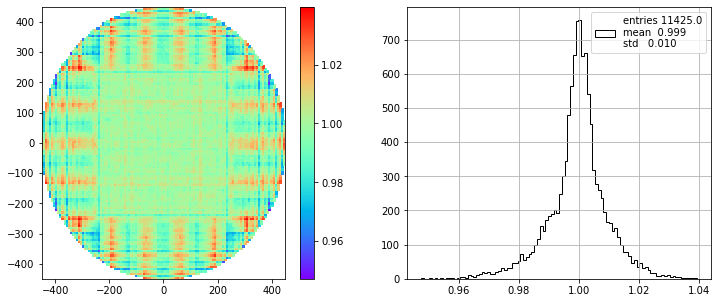

In [165]:
rat = icnorma/knorma
canvas = pltext.canvas(2, 2)
canvas(1)
plt.hist2d(xymesh[0].ravel(), xymesh[1].ravel(), weights = rat, bins = krmap.bin_edges);
plt.colorbar();
canvas(2)
pltext.hist(rat[xsel], 100);
canvas(2)

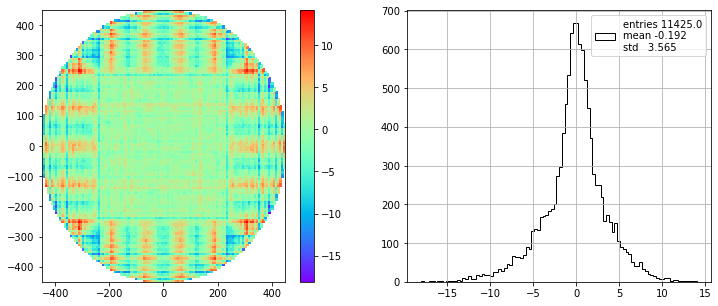

In [166]:
dif = icnorma - knorma
dif[~xsel] = np.nan
canvas = pltext.canvas(2, 2)
canvas(1)
plt.hist2d(xymesh[0].ravel(), xymesh[1].ravel(), weights = dif, bins = krmap.bin_edges);
plt.colorbar();
canvas(2)
pltext.hist(dif[xsel], 100);
canvas(2)

## Lifetime

In [172]:
eref = krmap.eref
dedt = krmap.dedt
lt   = eref/dedt

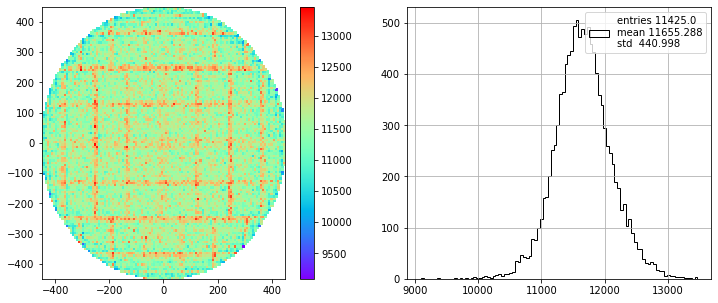

In [173]:
xsel   = (~np.isnan(lt)) & (lt > 0.)
canvas = pltext.canvas(2, 2)
canvas(1)
plt.hist2d(xymesh[0].ravel(), xymesh[1].ravel(), weights = lt.ravel(), bins = krmap.bin_edges);
plt.colorbar();
canvas(2)
pltext.hist(lt[xsel], 100);
canvas(2)

In [174]:
## Relation drift time - z

In [177]:
z/dt

0          0.84
1          0.84
3          0.84
5          0.84
6          0.84
           ... 
3624640    0.84
3624641    0.84
3624642    0.84
3624643    0.84
3624645    0.84
Length: 3111145, dtype: float64